# Topic modeling and NMF

## High level motivation:
Given a gigantic corpus of documents (e.g., 300,000 New York Times articles), how would you come up with a set of topics that could be mixed togeather to explain each document in your corpus? Maybe one document is a mixture of 70% about politics and 30% about health, but another document is 20% about politics, 30% about economics, and 50% about cooking. Being able to discover these topics could give deep insight into the existece of fundemental groupings within your data. Additionally, you could quickly create breif and high-level summaries of incomming (possibly large) documents by computing their topic mixtures. **Topic Modeling** is a method of automatic data comprehension and classification whereby latent topics are discovered within a corpus of documents, and used to label existing documents as well as new documents. Topic models are not restricted to news article type documents; models can be constructed from "documents" consisting of anything from web pages, to images, to ratings, to genetic sequences.

## Our topic model
In order to learn the topic structure, we must assume the existence of a topic structure from which our documents were generated. Therefore we let $V$ be the size of our vocabulary and let $K$ be the number of topics. We also assume a prior distribution $\tau$ from which we generate topic distributions for each document, as well as a multinomial distribution $A_k$ over the vocabulary associated with each topic $k$. A document is represented as a vector of word frequencies (bag-of-words model). We model a document as a convex combination (or mixture) of $K$ topics, and topics as distributions over a vocabulary of $V$ words (i.e., topic vectors of word frequencies).   

In this *mixture model* a document $d$ is generated by first selecting its distribution of topics (e.g., 80% politics, 20% economics, 0% cooking), which we denote $W_d \sim \tau.$ Then, for each word position $i$ in the document we chose a topic for that position $z_i \sim W_i,$ and finally a word from that topic $w_i \sim A_{z_i}.$  

We may represent each word-topic distribution as a column $A_k$ in a $V \times K$ word-topic matrix $A$, and similarly define the $K \times N$ topic-document matrix in terms of the randomly generated topic distributions $W_d$ of our $N$ documents. In this representation we can interpret the $V$ dimensional vector $Av$, where $v \in \mathbb{R}^K \text{ and } \sum_i v_i = 1$, to be the distribution of word frequencies for a document with topic weights $v$. Taking this product with $A$ for an infinite number of documents $W_d$ gives us the $V \times N$ matrix $M$ that encodes the expected word frequencies for $N$ documents.

For particular topic models like Latent Dirichlet Allocation (LDA) where the prior disribution $\tau$ over the topic distribution of a document is a Dirichlet distribution, we would like to learn the model's parameters. So, the learning problem for topic modeling is: given topic model how do we actually go about learning the matrix of word-topic distributions $A$ and the paramaters of $\tau$?  

Because MLE is NP-hard for more than one topic, typically people use MCMC algorithms to approximately infer the parameters (e.g., Gibbs sampling). The algorithm described in **Arora et. al. [2012b]** is a simple and highly performant alternative to methods like Gibbs sampling, and will be the focus of this notebook (along with descriptions of the algorithms implementation).

## Arora's topic inference modeling algorithm
In **Arora et. al. [2012a]** the authors prove there is a poly-time algorithm that learns the parameters of any topic model under the assumption that the word-topic matrix $A$ is *seperable*.

### Seperability assumption
A word-topic matrix $A$ is said to be $p$-seperable if there exists a $p > 0$ such that for all topics $k \in [K]$ there exists a word $i$ that satisfies $A[i,k] > p$ and $A[i,k'] = 0$ for $k' \neq k.$ These words are called *anchor words*, and are important because if we find one in a document then we know the document must at least partially be about the anchor word's corresponding topic, since the probability of that word being generated by any other topic is zero. An important observation is that if $A$ is sepreable then in the product $AW = M$ the rows of the matrix $W$ appear as scaled rows of $M$. This happens because for any given anchor word $i$ of $A$ corresponding to topic $k$, the row $A[i, :]$ has a single nonzero value $p_k$ at index $k$. Dotting $A[i, :]$ with $W$ to form row $i$ of $M$ we can see only row $W[k, :]$ appears scaled by $p_k$ in $M$, $M[i, :] = p_k * W[k, :].$ Given $M$, we can reconstruct $W$ using the rows of $M$, and then compute $A$ up to scaling.  

### Overview of the algorithm
The algorithm has two basic steps:  
1) **anchor selection**, which finds the anchor words.  
2) **recovery**, which recovers the matrix $A$ and the parameters of $\tau$.  

The input to both steps of the algorithm is the $V \times V$ word-word co-occurance matrix $Q$, which is normalized to sum to $1$ over all its entries.  

The `highLevel` function below implements the full algorithm, using helper functions to generate the input $Q$ for the find anchors stepand the recovery step.

In [1]:
def highLevel(M, params, K):
    """
    Input: word by document sparse matrix of word counts M,
            params including tolerance parameter eps > 0 and more,
            number of anchors K.
    Output: word-topic matrix A, topic-topic matrix R.
    """
    print "Recovering word-topic matrix and topic-topic matrix"
    print "parameters are: vocabulary size = %s, number of documents = %s, number of topics = %s, and tolerance = %s" \
                    % (M.shape[0], M.shape[1], K, params.eps)
    candidates = getCandidates(M.tocsr(), params)
    print "calculating word-word co-occurance matrix"
    t0 = time.time()
    Q = wordCooccurrence(M)
    print "Q calculated in: ", time.time() - t0
    print "finding anchors"
    t0 = time.time()
    anchors = findAnchors(Q, K, params, candidates)
    print "anchors calculated in: ", time.time() - t0
    print "recovering topic-document matrix A"
    Q2 = Q.copy()
    t0 = time.time()
    A, iterations = recoverL2(Q, anchors, params.eps)
    print "A calculated in: ", time.time() - t0
    return A, anchors, Q2

In [2]:
def getCandidates(M, params):
    candidate_anchors = []
    for i in xrange(M.shape[0]):
        if M[i, :].nnz > params.anchor_thresh:
            candidate_anchors.append(i)
    return candidate_anchors

In [3]:
# Given a sparse CSC document matrix M (with floating point entries),
# computes the word-word correlation matrix Q
def wordCooccurrence(M):
    vocabSize = M.shape[0]
    numdocs = M.shape[1]
    
    diag_M = np.zeros(vocabSize)

    for d in xrange(M.indptr.size - 1):
        
        # start and end indices for document d
        start = M.indptr[d]
        end = M.indptr[d + 1]
        
        nd = np.sum(M.data[start:end])
        row_indices = M.indices[start:end]
        
        if nd*(nd-1) != 0:
            diag_M[row_indices] += M.data[start:end]/(nd*(nd-1))
            M.data[start:end] = M.data[start:end]/math.sqrt(nd*(nd-1))
    
    
    Q = M*M.transpose()/numdocs
    Q = Q.todense()
    Q = np.array(Q, copy=False)

    diag_M = diag_M/numdocs
    Q = Q - np.diag(diag_M)
    
    return Q

In `wordCooccurance` we loop through each document to calculate `diag_M`, which is incremented by each documents word counts scaled by $n_d (n_d - 1)$, where $wpd$ is the total number of words in that document. After incrementing `diag_M` we then scale each documents counts by $\sqrt{n_d (n_d - 1)}$. At the end of the loop on a document $d$ we could form the matrix `M.data[start:end] * M.data[start:end].T - np.diag(diag_M)`, which is equal to $\frac{1}{n_d(n_d - 1)} \sum_{i,j \in [n_d], i \neq j} e_{z_{d,i}} e_{z_{d,j}}^T$ where $z_{d,i}$ denotes the word in document $d$ at position $i$. Since the expected value of all terms $e_{z_{d,i}} e_{z_{d,j}}^T$ is just $(AW_d)(AW_d)^T$, we have that in expectation `M.data[start:end] * M.data[start:end].T - np.diag(diag_M)` is equal to $\frac{1}{n_d(n_d - 1)}( \mathbb{E}[M_dM_d^T] - \mathbb{E}[\mathrm{diag}(M_d)]) = \frac{1}{n_d(n_d - 1)}( \mathbb{E}[M_d]\mathbb{E}[M_d]^T + \mathrm{Cov}(M_d) - \mathrm{diag}(\mathbb{E}[M_d])) = A W_d W_d^T A^T$, conditioned on $W_d$. We calculate $Q$ by subtracting the diagonal matrix of our running scaled word counts from the appropiately scaled `M.data[start:end] * M.data[start:end].T` (cancels out the diagonal term in the covariance matrix, thereby making it the unbiased estimator we were looking for) and dividing by number of documents, which has the expectation  $\frac{1}{N} \sum_{d=1}^N (AW_d)(AW_d)^T$ conditioned on the $W_d$'s. Later on we will show how performing inference on the word-word co-occurance statistics dramatically speeds up our algorithm, allowing us to only need to pass through our corpus once when calculating $Q$.

Given infinite documents, the convex hull of the rows of $\bar{Q}$ will be a simplex with vertices corresponding to anchor words. Unfortunately, we don't have an infinite supply of documents, therefore the best we can do is approximate this set of vertices. Given $V$ points $d_1, \dots, d_V$  that are each a perturbation of $a_1, \dots, a_V$ whose convex hull forms a simplex $P$, our goal is to approximate the vertices of $P$.  

**Main idea of algorithm:** on each iteration the algorithm finds the furthest point from the subspace spanned by the set of current "anchors" $S$. If you already found a few vertices that are each close to different anchor words, you want to look for new anchor words as far away from $\mathbb{span}(S)$ as possible, since anchor words don't lie within  the span of any other vertices.  

This algorithm also utilized dimentionality reduction through a random subspace projection (Achlioptas 2003). The stabalized Gram-Schmidt process is responsible for orthonormalizing the set of current anchors, against whose span all distances are being compared (evidently Gram-Schmidt isn't numerically stable and often results in nonorthogonality!).

### findAnchors algorithm
Input: $V$ points in $\mathbb{R}^V$ almost in a simplex (corresponding to $\bar{Q}$'s rows) with $K$ vertices and $\epsilon > 0.$  
Output: $K$ points that are close to the vertices of the simplex (i.e., approximate anchor words).  

In [4]:
def findAnchors(Q, K, params, candidates):
    # Random number generator for generating dimension reduction
    prng_W = RandomState(params.seed)

    new_dim = params.new_dim

    # row normalize Q
    row_sums = Q.sum(1)
    for i in xrange(len(Q[:, 0])):
        Q[i, :] = Q[i, :]/float(row_sums[i])

    # Reduced dimension random projection method for recovering anchor words
    Q_red = Random_Projection(Q.T, new_dim, prng_W)
    Q_red = Q_red.T
    (anchors, anchor_indices) = Projection_Find(Q_red, K, candidates)

    # restore the original Q
    for i in xrange(len(Q[:, 0])):
        Q[i, :] = Q[i, :]*float(row_sums[i])

    return anchor_indices

In [5]:
def Projection_Find(M_orig, r, candidates):

    n = M_orig[:, 0].size
    dim = M_orig[0, :].size

    M = M_orig.copy()
    
    # stored recovered anchor words
    anchor_words = np.zeros((r, dim))
    anchor_indices = np.zeros(r, dtype=np.int)

    # store the basis vectors of the subspace spanned by the anchor word vectors
    basis = np.zeros((r-1, dim))


    # find the farthest point p1 from the origin
    max_dist = 0
    #for i in range(0, n):
    for i in candidates:
        dist = np.dot(M[i], M[i])
        if dist > max_dist:
            max_dist = dist
            anchor_words[0] = M_orig[i]
            anchor_indices[0] = i

    # let p1 be the origin of our coordinate system
    #for i in range(0, n):
    for i in candidates:
        M[i] = M[i] - anchor_words[0]


    # find the farthest point from p1
    max_dist = 0
    for i in candidates:
        dist = np.dot(M[i], M[i])
        if dist > max_dist:
            max_dist = dist
            anchor_words[1] = M_orig[i]
            anchor_indices[1] = i
            basis[0] = M[i]/np.sqrt(np.dot(M[i], M[i]))


    # stabilized gram-schmidt which finds new anchor words to expand our subspace
    for j in range(1, r - 1):

        # project all the points onto our basis and find the farthest point
        max_dist = 0
        #for i in range(0, n):
        for i in candidates:
            M[i] = M[i] - np.dot(M[i], basis[j-1])*basis[j-1]
            dist = np.dot(M[i], M[i])
            if dist > max_dist:
                max_dist = dist
                anchor_words[j + 1] = M_orig[i]
                anchor_indices[j + 1] = i
                basis[j] = M[i]/np.sqrt(np.dot(M[i], M[i])) 
                
    # convert numpy array to python list
    anchor_indices_list = []
    for i in range(r):
        anchor_indices_list.append(anchor_indices[i])
    
    return (anchor_words, anchor_indices_list)

In [6]:
# Project the columns of the matrix M into the
# lower dimension new_dim using Achlioptas 2003 method
def Random_Projection(M, new_dim, prng):
    # transformer = random_projection.SparseRandomProjection(new_dim)
    # M_red = transformer.fit_transform(M)
    old_dim = M[:, 0].size
    p = np.array([1./6, 2./3, 1./6])
    c = np.cumsum(p)
    randdoubles = prng.random_sample(new_dim*old_dim)
    R = np.searchsorted(c, randdoubles)
    R = math.sqrt(3)*(R - 1)
    R = np.reshape(R, (new_dim, old_dim))
    
    M_red = np.dot(R, M)
    return M_red

## recoverL2 algorithm
For two words in a document $w_1,w_2$ and their topic assignments $z_1,z_1$ we have the following identities:
1. $A[i,k] = p(w_1 = i \vert z_1 = k)$  
2. $Q[i,j] = p(w_1 = i, w_2 = j)$  
3. $\bar{Q}[i,j] = p(w_2 = j \vert w_1 = i)$  

Let $S$ be the set of anchor word indexes. The convex hull formed by the rows of $\bar{Q}$ indexed by elements of $S$ contains all other rows of $\bar{Q}$. To see this, note that for anchor words $s_k$, we can show $$\bar{Q}[s_k,j] = p(w_2 = j \vert z_1 = k).$$ For all other words $i$, we also have $$\bar{Q}[i,j] = \sum_k p(z_1 = k \vert w_1 = i) p(w_2 = j \vert z_1 = k).$$ If we denote $p(z_1 = k \vert w_1 = i)$ as the coefficent $\alpha_{i,k}$ we can rewrite the above expression more compactly as $\bar{Q}[i,j] = \sum_k \alpha[i,k] \bar{Q}[s_k,j].$ Since $\alpha$'s rows consist of non-negative probabilities that sum to one, we have that any row of $\bar{Q}$ lies in the convex hull of the rows corresponding to the anchor words. The mixing weights of these convex combinations give us $p(z_1 \vert w_1 = i).$ Using this togeather with $p(w_1 = i)$, we can recover $A$ by applying Bayes' rule: $$A[i,k] = p(w_1 \vert z_1 = k) = \frac{p(z_1 \vert w_1 = i) p(w_1 = i)}{\sum_{i'} p(z_1 = k | w_1 = i') p(w_1 = i')}.$$ We calculate $p(w_1 = i)$ in terms of $Q$ by noting the following equation $$\sum_j Q[i,j] = \sum_j p(w_1 = i, w_2 = j) = p(w_1 = i).$$ With all the terms finally computed, we recover $A$ via the application of Bayes' theorem above.  

For each row of the empirical row normalized co-occurance matrix $\hat{Q}$, `recoverL2` finds the coefficents $p(z_1 \vert w_1 = i)$ that best reconstruct the row as a convex combination of rows corresponding to anchor words using the exponentiated gradient algorithm `quadSolveExpGrad`. Then by applying Bayes' theorem as before, `recoverL2` can recover $A$.

In [7]:
def recoverL2(Q, anchors, eps=10**(-7)):
    """
    Input: Matrix Q, Set of words S, tolerance parameter eps
    Output: Matrices A,R
    """
    Qold = np.copy(Q)
    V = Q.shape[0]
    K = len(anchors)
    A = np.matrix(np.zeros((V,K)))
    iterations = []
    
    # Store the normalization constnts P_w = Q*ones
    P_w = np.matrix(np.diag(np.dot(Q, np.ones(V))))
    for v in xrange(V):
        if np.isnan(P_w[v,v]):
            P_w[v,v] = 10**(-16)
    
    #normalize the rows of Q_prime
    for v in xrange(V):
        Q[v,:] = Q[v,:]/Q[v,:].sum()
            
    X = Q[anchors, :]
    XXT = np.dot(X, X.transpose())

    for i in xrange(V):
        y = Q[i, :]
        alpha, it = recover(y,X,i,anchors,XXT,eps)
        A[i, :] = alpha
        iterations.append(it)
    
    #rescale A matrix
    #Bayes rule says P(w|z) proportional to P(z|w)P(w)

    A = P_w * A

    #normalize columns of A. This is the normalization constant P(z)
    colsums = A.sum(0)

    for k in xrange(K):
        A[:, k] = A[:, k]/A[:,k].sum()
    
    A = np.array(A)
#     R = np.dot(np.linalg.pinv(A), np.dot(Qold, np.linalg.pinv(A).T))
#     R = np.dot(A.conj().T, np.dot(Qold, A.conj()))

    return A, iterations

In [8]:
def recover(y,x,i,anchors,XXT,eps):
    K = len(anchors)
    alpha = np.zeros(K)
    gap = None
    if i in anchors:
        alpha[anchors.index(i)] = 1
        it = -1
        dist = 0
        stepsize = 0

    else:
        # alpha, it, dist, stepsize, gap = quadSolveExpGrad(y, x, eps, None, XXT)
        alpha, it = quadSolveExpGrad(y, x, eps, None, XXT)
        if np.isnan(alpha).any():
                alpha = np.ones(K)/K

    return alpha, it

In [9]:
def quadSolveExpGrad(y, X, eps, alpha=None, XX=None): 
    """Exponentiated gradient method
    Input: vector y, matrix X, tolerance parameter eps
    non-negative normalized vector alpha close to alpha'
    that minimizes the L2 distance between y and X*alpha
    finds alpha within eps of the alpha' minimizing the objective function obj(y, Xa) = aXXa - 2*aXY + YY,
    where aXXA = dot(dot(alpha, dot(x, x.transpose())), alpha.transpose())
    and aXY and YY are defined similarly.
    Output: non-negative normalized vector alpha close to alpha' that minimizes the L2 distance between y and X*alpha,
    number of iterations it,
    final value of the objective function new_obj,
    amount to change alpha by stepsize,
    closeness to minimal alpha solution gap"""
    
    c1 = 10**(-4)
    c2 = 0.75
    if XX is None:
        print 'making XXT'
        XX = np.dot(X, X.transpose())

    XY = np.dot(X, y)
    YY = float(np.dot(y, y))


    (K,n) = X.shape
#     if alpha is None:
#         alpha = np.ones(K)/K
    alpha = np.ones(K)/K

    old_alpha = np.copy(alpha)
    log_alpha = np.log(alpha)
    old_log_alpha = np.copy(log_alpha)

    it = 1 
    aXX = np.dot(alpha, XX)
    aXY = float(np.dot(alpha, XY))
    aXXa = float(np.dot(aXX, alpha.transpose()))

    grad = 2*(aXX-XY)
    new_obj = aXXa - 2*aXY + YY

    old_grad = np.copy(grad)

    stepsize = 1
    repeat = False
    decreased = False
    gap = float('inf')

    while 1:
        eta = stepsize
        old_obj = new_obj
        old_alpha = np.copy(alpha)
        old_log_alpha = np.copy(log_alpha)

        if new_obj == 0 or stepsize == 0:
            break

#         if it % 1000 == 0:
#             print "\titer", it, new_obj, gap, stepsize
        it += 1
        #update
        log_alpha -= eta*grad
        #normalize
        log_alpha -= logsum_exp(log_alpha)
        #compute new objective
        alpha = np.exp(log_alpha)

        aXX = np.dot(alpha, XX)
        aXY = float(np.dot(alpha, XY))
        aXXa = float(np.dot(aXX, alpha.transpose()))

        old_obj = new_obj
        new_obj = aXXa - 2*aXY + YY
#         old_obj, new_obj = new_obj, aXXa - 2 * aXY + YY
        if not new_obj <= old_obj + c1*stepsize*np.dot(grad, alpha - old_alpha): #sufficient decrease
            stepsize /= 2.0 #reduce stepsize
            alpha = old_alpha 
            log_alpha = old_log_alpha
            new_obj = old_obj
            repeat = True
            decreased = True
            continue

        #compute the new gradient
        old_grad = np.copy(grad)
        grad = 2*(aXX-XY)
#         old_obj, new_obj = new_obj, aXXa - 2 * aXY + YY
        
        if (not np.dot(grad, alpha - old_alpha) >= c2*np.dot(old_grad, alpha-old_alpha)) and (not decreased): #curvature
            stepsize *= 2.0 #increase stepsize
            alpha = old_alpha
            log_alpha = old_log_alpha
            grad = old_grad
            new_obj = old_obj
            repeat = True
            continue

        decreased = False

        lam = np.copy(grad)
        lam -= lam.min()
        
        gap = np.dot(alpha, lam)
        convergence = gap
        if (convergence < eps):
            break

    return alpha, it #, it, new_obj, stepsize, gap

def logsum_exp(y):
    m = y.max()
    return m + np.log((np.exp(y - m)).sum())

## Experimenting with the algorithm

In [10]:
from __future__ import division
import wget
import gzip
#import scipy
# from sklearn import random_projection
import time
import math
import scipy.sparse
import scipy.io
import numpy as np
from numpy.random import RandomState

# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.style.use("ggplot")

If you don't have any datasets for topic modeling, here are a couple:

In [ ]:
vocabUrl = "http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.nips.txt"
docwordUrl = "http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.nips.txt.gz"
wget.download(vocabUrl)
wget.download(docwordUrl)

# NY Times articles dataset (~300,000 documents, ~100,00 vocabulary, ~100,000,000 words)
# vocabUrl = "http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.nytimes.txt"
# docwordUrl = "http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.nytimes.txt.gz"
# wget.download(vocabUrl)
# wget.download(docwordUrl)

Transform the dataset into a sparse array below:

In [42]:
# Make nips (or new york times) dataset!
input_matrix = "datasets/nips/docword.nips.txt.gz"
full_vocab = "datasets/nips/vocab.nips.txt"
# input_matrix = "datasets/nyt/docword.nytimes.txt"
# full_vocab = "datasets/nyt/vocab.nytimes.txt"

firstNdocs = 'all'
# output_matrix_name = "datasets/nyt/M_nytimes.%s.mat" % (firstNdocs) # "M_nips.full_docs.mat"
output_matrix_name = "datasets/nips/M_nips.%s.mat" % (firstNdocs)

print "opening file"

# with gzip.open(input_matrix, 'r') as infile:
with open(input_matrix, 'r') as infile:
    num_docs = int(infile.readline())
    num_words = int(infile.readline())
    nnz = int(infile.readline())

    print "number of docs = %s, number of words = %s, number nonzero = %s" % (num_docs, num_words, nnz)

    data = []        # counts
    row = []         # row (document) indices
    col = []         # column (word) indices

    print "constructing word-document matrix"
    t0 = time.time()
    if firstNdocs == 'all':
        for i, l in enumerate(infile):
            d, w, v = (int(x) for x in l.split())
            if not i % 100000:
                print i, time.time() - t0, d, w, v
                t0 = time.time()
            col.append(d-1)
            row.append(w-1)
            data.append(v)
    else:
        for i, l in enumerate(infile):
            d, w, v = (int(x) for x in l.split())
            if not i % 100000:
                print i, time.time() - t0, d, w, v
                t0 = time.time()

            if d == firstNdocs + 1:
                break
            col.append(d-1)
            row.append(w-1)
            data.append(v)
            # M[w-1, d-1] = v
    M = scipy.sparse.csr_matrix((data, (row, col)))

scipy.io.savemat(output_matrix_name, {'M' : M}, oned_as='column')

opening file
number of docs = 300000, number of words = 102660, number nonzero = 69679427
constructing word-document matrix
0 0.00190401077271 1 413 1
100000 0.503263950348 435 15627 1
200000 0.410134077072 875 40446 1
300000 0.420979976654 1343 48964 1
400000 0.378053188324 1818 35083 1
500000 0.371774196625 2277 26610 1
600000 0.373458862305 2736 30051 2
700000 0.407560110092 3201 27006 2
800000 0.419481992722 3672 22968 1
900000 0.3887591362 4139 33955 1
1000000 0.40186214447 4582 30239 1
1100000 0.385185003281 5013 28051 4
1200000 0.408826112747 5471 22924 2
1300000 0.390644788742 5955 19865 1
1400000 0.376908063889 6432 16376 1
1500000 0.395451068878 6891 20298 1
1600000 0.387594938278 7318 39838 2
1700000 0.369194984436 7802 44101 9
1800000 0.399671077728 8262 444 1
1900000 0.456289052963 8716 30246 1
2000000 0.466792106628 9178 1907 2
2100000 0.405920982361 9622 22554 2
2200000 0.4381711483 10069 37424 1
2300000 0.411858081818 10527 13603 1
2400000 0.40091919899 10962 5273 4
250

In [14]:
def truncateData(matrixName, full_vocab, numDocs=None, cutoff = 1000):
    M = scipy.io.loadmat(matrixName)['M']
    output_vocab = full_vocab + ".trunc"
    
#     randIndices = np.random.choice(range(M.shape[1]), numDocs, replace=False)

    print "old num words = %s, old num docs = %s" % M.shape

    table = dict()
    numwords = 0
    with open(full_vocab, 'r') as f:
        for line in f:
            table[line.rstrip()] = numwords
            numwords += 1

    remove_word = [False]*numwords

    # Read in the stopwords
    with open('datasets/stopwords.txt', 'r') as f:
        for line in f:
            if line.rstrip() in table:
                remove_word[table[line.rstrip()]] = True

#     M = M[:,randIndices].tocsr() # M.tocsr()
#     M = M.tocsr()
    if numDocs:
        randIndices = np.random.choice(range(M.shape[1]), numDocs, replace=False)
        M = M[:,randIndices].tocsr()
    else:
        M = M.tocsr()
    
    new_indptr = np.zeros(M.indptr.shape[0], dtype=np.int32)
    new_indices = np.zeros(M.indices.shape[0], dtype=np.int32)
    new_data = np.zeros(M.data.shape[0], dtype=np.float64)

    indptr_counter = 1
    data_counter = 0

    for i in xrange(M.indptr.size - 1):

        # if this is not a stopword
        if not remove_word[i]:

            # start and end indices for row i
            start = M.indptr[i]
            end = M.indptr[i + 1]

            # if number of distinct documents that this word appears in is >= cutoff
            if (end - start) >= cutoff:
                new_indptr[indptr_counter] = new_indptr[indptr_counter-1] + end - start
                new_data[new_indptr[indptr_counter-1]:new_indptr[indptr_counter]] = M.data[start:end]
                new_indices[new_indptr[indptr_counter-1]:new_indptr[indptr_counter]] = M.indices[start:end]
                indptr_counter += 1
            else:
                remove_word[i] = True

    new_indptr = new_indptr[0:indptr_counter]
    new_indices = new_indices[0:new_indptr[indptr_counter-1]]
    new_data = new_data[0:new_indptr[indptr_counter-1]]

    M = scipy.sparse.csr_matrix((new_data, new_indices, new_indptr))
    Mtrunc = M.tocsc()

    print "new num words = %s, new num docs = %s" % M.shape

    # Output the new vocabulary
    output = open(output_vocab, 'w')
    row = 0
    with open(full_vocab, 'r') as f:
        for line in f:
            if not remove_word[row]:
                output.write(line)
            row += 1
    output.close()
    
    return Mtrunc

In [12]:
class Params(object):
    def __init__(self, seed=int(time.time()), top_words=10, new_dim=1000, eps=10e-7, anchor_thresh=100):
        self.seed = seed
        self.top_words = top_words
        self.new_dim = new_dim
        self.eps = eps
        self.anchor_thresh = anchor_thresh

In [21]:
input_matrix = "datasets/nips/M_nips.all.mat"
full_vocab = "datasets/nips/vocab.nips.txt"
numDocs = 1500
thresh = 100
cutoff = 50

# input_matrix = "datasets/nyt/M_nytimes.all.mat"
# full_vocab = "datasets/nyt/vocab.nytimes.txt"
# numDocs = 50000
# thresh = 500 # Anchor words must be in more than this number of documents
# cutoff = 200 # Words must be in at least this number of documents, otherwise they are pruned.

Mtrunc = truncateData(input_matrix, full_vocab, numDocs=numDocs, cutoff=cutoff)
params = Params(seed=100, anchor_thresh=thresh, top_words=6, eps=1e-5)
params.dictionary_file = full_vocab + ".trunc"

old num words = 102660, old num docs = 300000
new num words = 8367, new num docs = 50000


### Whole algorithm in action:

In [22]:
K = 100 # Number of topics to learn
t0 = time.time()
A, anchors, Q = highLevel(Mtrunc.copy(), params, K)
print time.time() - t0

Recovering word-topic matrix and topic-topic matrix
parameters are: vocabulary size = 8367, number of documents = 50000, number of topics = 100, and tolerance = 1e-05
calculating word-word co-occurance matrix
Q calculated in:  36.6643409729
finding anchors
anchors calculated in:  8.71388411522
recovering topic-document matrix A
A calculated in:  39.8705518246
88.4953508377


View the words most associated with each topic in order of descending importance.

In [23]:
print "Each topic's anchor word followed by a list of keywords in order of descending importance.\n"
vocab = file(full_vocab + ".trunc").read().strip().split()
for k in xrange(K):
    topwords = np.argsort(A[:, k])[-10:][::-1]
    print vocab[anchors[k]], ':',
    for w in topwords:
        print vocab[w],
    print ""

Each topic's anchor word followed by a list of keywords in order of descending importance.

advisory : advisory premature advise error wines client nyt zzz_islamabad fort held 
zzz_karl_horwitz : zzz_karl_horwitz financial lifestyle zzz_new_york zzz_americas mail general sector miles zzz_los_angeles 
tonight : tonight zzz_boston_globe zzz_x_x_x spot zzz_new_york zzz_fla light court zzz_chicago development 
copy : copy fall zzz_diane question expected answer version killed schedule zzz_new_york 
test : test export function mark thread housed media student check paragraph 
file : file zzz_boston_globe zzz_new_york spot sport zzz_fla zzz_los_angeles notebook internet zzz_calif 
solo : con dice solo son mayor era director sin sector embargo 
zzz_portland : zzz_portland coach assistant season team player job head coaching coaches 
publication : publication premature wines nyt zzz_islamabad greenhouse zzz_lee substitute risen advise 
wire : wire mandatory finance running today zzz_x_x_x prod

Calculate and plot the topic-topic correlation matrix to view potential correlations between topics.

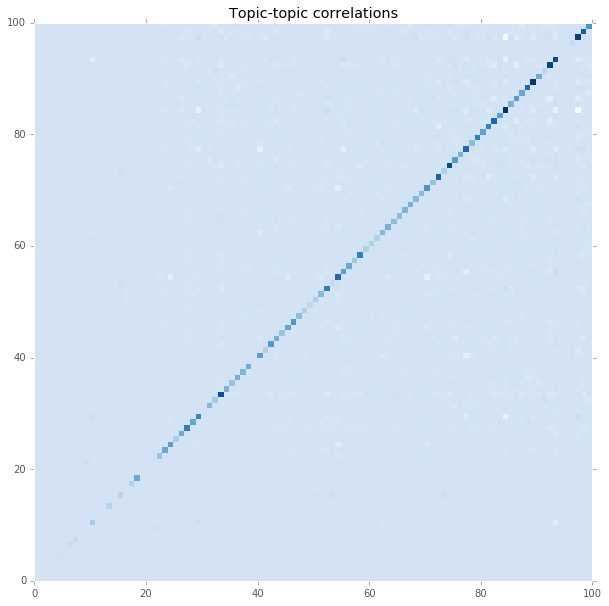

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

R = np.dot(np.linalg.pinv(A), np.dot(Q, np.linalg.pinv(A.T))) # Computing the topic-topic covariance matrix
plt.figure(figsize=(10,10))
plt.pcolor(R, norm=None, cmap='Blues')
plt.title("Topic-topic correlations")

Calculates the parameters of $\alpha$ for the topic-document Dirichlet distribution $\tau.$

In [27]:
def calcAlpha(R):
    alphaOverAlpha0 = np.dot(R, np.ones(R.shape[0]))
    i = alphaOverAlpha0.argmin()
    u, v = R[i,i], alphaOverAlpha0[i]
    alpha0 = (1 - (u/v))/((u/v) - v)
    alpha = alpha0 * alphaOverAlpha0
    return alpha, alpha0

In [28]:
alpha, alpha0 = calcAlpha(R)
alpha, alpha0

(array([ 0.01482729,  0.01684305,  0.04064545,  0.0371535 ,  0.09473873,
         0.03836407,  0.16079619,  0.10067844,  0.02738376,  0.06537202,
         0.49560479,  0.04703361,  0.03167202,  0.26383021,  0.03998449,
         0.53474516,  0.04023191,  0.40552972,  0.75414944,  0.05027042,
         0.03312532,  0.17254458,  0.45826832,  0.57504078,  0.69894165,
         0.49661029,  0.60142218,  0.37659544,  0.79724495,  1.11137475,
         0.25841612,  0.66166829,  0.55120452,  0.37938664,  0.48810023,
         0.51435209,  0.54211884,  0.36812331,  0.55316861,  0.19576816,
         0.6076717 ,  0.43812427,  0.75566975,  0.58344115,  0.31518189,
         0.75048077,  0.39136663,  0.58293235,  0.18629543,  0.52199163,
         0.33368786,  0.49258965,  0.52855665,  0.28093796,  0.90778155,
         0.40971158,  0.4640747 ,  0.41657754,  1.04263171,  0.24761961,
         0.34118148,  0.41079399,  0.48217188,  0.67416518,  0.4514224 ,
         0.34667813,  0.78944787,  0.53289068,  0.6

### Papers discussed:  
**Arora et. al. [2012a]:** Arora, S., Ge, R., and Moitra, A. Learning topic models – going beyond svd. In FOCS, 2012b.  
**Arora et. al. [2012b]:** Sanjeev Arora, Rong Ge, Yoni Halpern, David M. Mimno, Ankur Moitra, David Sontag, Yichen Wu, and Michael Zhu. 2013. A practical algorithm for topic modeling with provable guarantees.